# Project: Advanced Lane Finding

### Pipeline procedure
1. Calculate distortion coefficients, camera mtx
2. Gradient & color filtering
3. Calcuate perspective transform matrix
4. Undistort & unwarp
5. Find lane lines
    a. Use sliding window for first image or when reset is needed
    b. Use lookback for subsequent images

### Import libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

%matplotlib inline

### 1. Camera Calibration

In [2]:
# prepare object points
nx = 9
ny = 6
def get_object_image_points(images, nx=9, ny=6, debug=False):
    """Iterates through calibration images, find corners and 
    returns object points, image points (for camera calibration).
    Set debug to true to see found corners"""
    
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[range(nx),range(ny)].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            # Draw and display the corners
            if debug:
                img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
                plt.figure()
                plt.imshow(img)
    if debug:
        cv2.destroyAllWindows()
    return objpoints, imgpoints

In [3]:
def undistort_image(img, mtx, dist):
    return cv2.undistort(img, mtx, dist, None, mtx)

def calibrate_camera(glob_key='camera_cal/calibration*.jpg', nx=9, ny=6, debug=False):
    # Make a list of calibration images
    images = glob.glob(glob_key)
    
    # Get Object, Image Points
    objpoints, imgpoints = get_object_image_points(images=images, nx=nx, ny=ny, debug=debug)
    
    # Get Camera Image Size
    image_size=cv2.imread(images[0]).shape[1::-1]
    
    # Calibrate Camera from Object Points, Image Points
    retval, mtx, dist, rvecs, tvecs = \
        cv2.calibrateCamera(objpoints, imgpoints, image_size, None, None)
        
    if debug:
        # Show undistorted images
        for fname in images:
            img = cv2.imread(fname)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img)
            ax1.set_title('Original Image', fontsize=50)
            ax2.imshow(undistort_image(img, mtx=mtx, dist=dist))
            ax2.set_title('Undistorted Image', fontsize=50)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return mtx, dist

In [4]:
mtx, dist = calibrate_camera(glob_key='camera_cal/calibration*.jpg', nx=9, ny=6, debug=False)

### 2. Gradient & Color Filtering

In [5]:
def apply_gradx_color_filter(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    """Apply sobel filter along x and s-channel color filter"""
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # # Stack each channel
    # color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    combined = np.zeros_like(s_channel)
    combined[((sxbinary == 1)  | (s_binary == 1))] = 1
    
    return combined

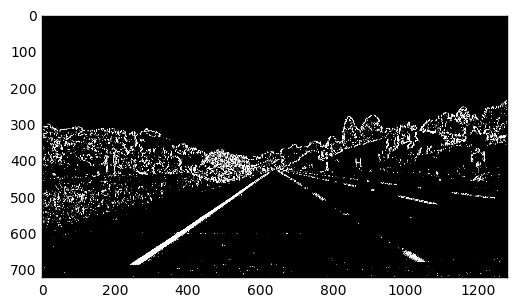

In [6]:
img_straight_lines = mpimg.imread("test_images/straight_lines1.jpg")
img_stlines_filt = apply_gradx_color_filter(img_straight_lines)
# plt.imshow(img_straight_lines)
plt.imshow(img_stlines_filt, cmap='gray')

#### Reuse code from project 1 to get lane lines for perspective view

In [7]:
from SimpleLaneFinding import simple_line_finding

In [8]:
img_straight_lines = mpimg.imread("test_images/straight_lines1.jpg")

img_simple_lines, lane_lines = simple_line_finding(img_straight_lines)

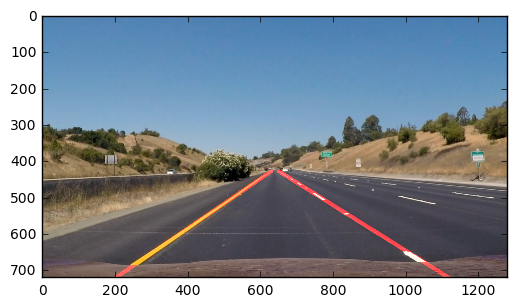

In [9]:
plt.imshow(img_simple_lines)

In [10]:
print(lane_lines)

[[[ 650  429 1115  720]]

 [[ 629  429  204  720]]]


### 3. Calcuate Perspective Transform Matrix

In [11]:
def get_perspective_matrix(src, dst):
    """
    Calculate and return perspective transform matrix M from 'src', 'dst' points
    """
    return cv2.getPerspectiveTransform(src, dst)

def warp_perspective(img, M):
    """
    `img` is the undistored image
    `M` is the perspective transform matrix
    """
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), 
                                      flags=cv2.INTER_LINEAR)
    return warped

In [12]:
def get_point_between(pt1, pt2, fraction):
    return pt1 + fraction*(pt2 - pt1)

In [13]:
def lane_lines_to_src_dst(lane_lines, y_size):
    left_x_bottom = lane_lines[1][0][2]
    left_x_top = lane_lines[1][0][0]
    left_y_bottom = lane_lines[1][0][3]
    left_y_top = lane_lines[1][0][1]

    right_x_bottom = lane_lines[0][0][2]
    right_x_top = lane_lines[0][0][0]
    right_y_bottom = lane_lines[0][0][3]
    right_y_top = lane_lines[0][0][1]

    left_x_top_adj = get_point_between(left_x_bottom, left_x_top, 0.8)
    left_y_top_adj = get_point_between(left_y_bottom, left_y_top, 0.8)
    left_x_bottom_adj = get_point_between(left_x_bottom, left_x_top, 0.05)
    left_y_bottom_adj = get_point_between(left_y_bottom, left_y_top, 0.05)

    right_x_top_adj = get_point_between(right_x_bottom, right_x_top, 0.8)
    right_y_top_adj = get_point_between(right_y_bottom, right_y_top, 0.8)
    right_x_bottom_adj = get_point_between(right_x_bottom, right_x_top, 0.05)
    right_y_bottom_adj = get_point_between(right_y_bottom, right_y_top, 0.05)

    src = np.float32([
            [left_x_bottom_adj, left_y_bottom_adj],
            [left_x_top_adj, left_y_top_adj],
            [right_x_bottom_adj, right_y_bottom_adj],
            [right_x_top_adj, right_y_top_adj]
        ])

    left_x_warp = get_point_between(left_x_bottom_adj, right_x_bottom_adj, 0.15)
    right_x_warp = get_point_between(left_x_bottom_adj, right_x_bottom_adj, 0.85)

    dst = np.float32([
            [left_x_warp, y_size],
            [left_x_warp, 0],
            [right_x_warp, y_size],
            [right_x_warp, 0],
        ])
    return src, dst

In [14]:
src, dst = lane_lines_to_src_dst(lane_lines=lane_lines, y_size=img_straight_lines.shape[0])
M = get_perspective_matrix(src, dst)

### 4. Undistort & Unwarp

In [15]:
img_undistort = undistort_image(img=img_straight_lines, mtx=mtx, dist=dist)
img_unwarp = warp_perspective(img=img_undistort, M=M)

#### Review unwarped image

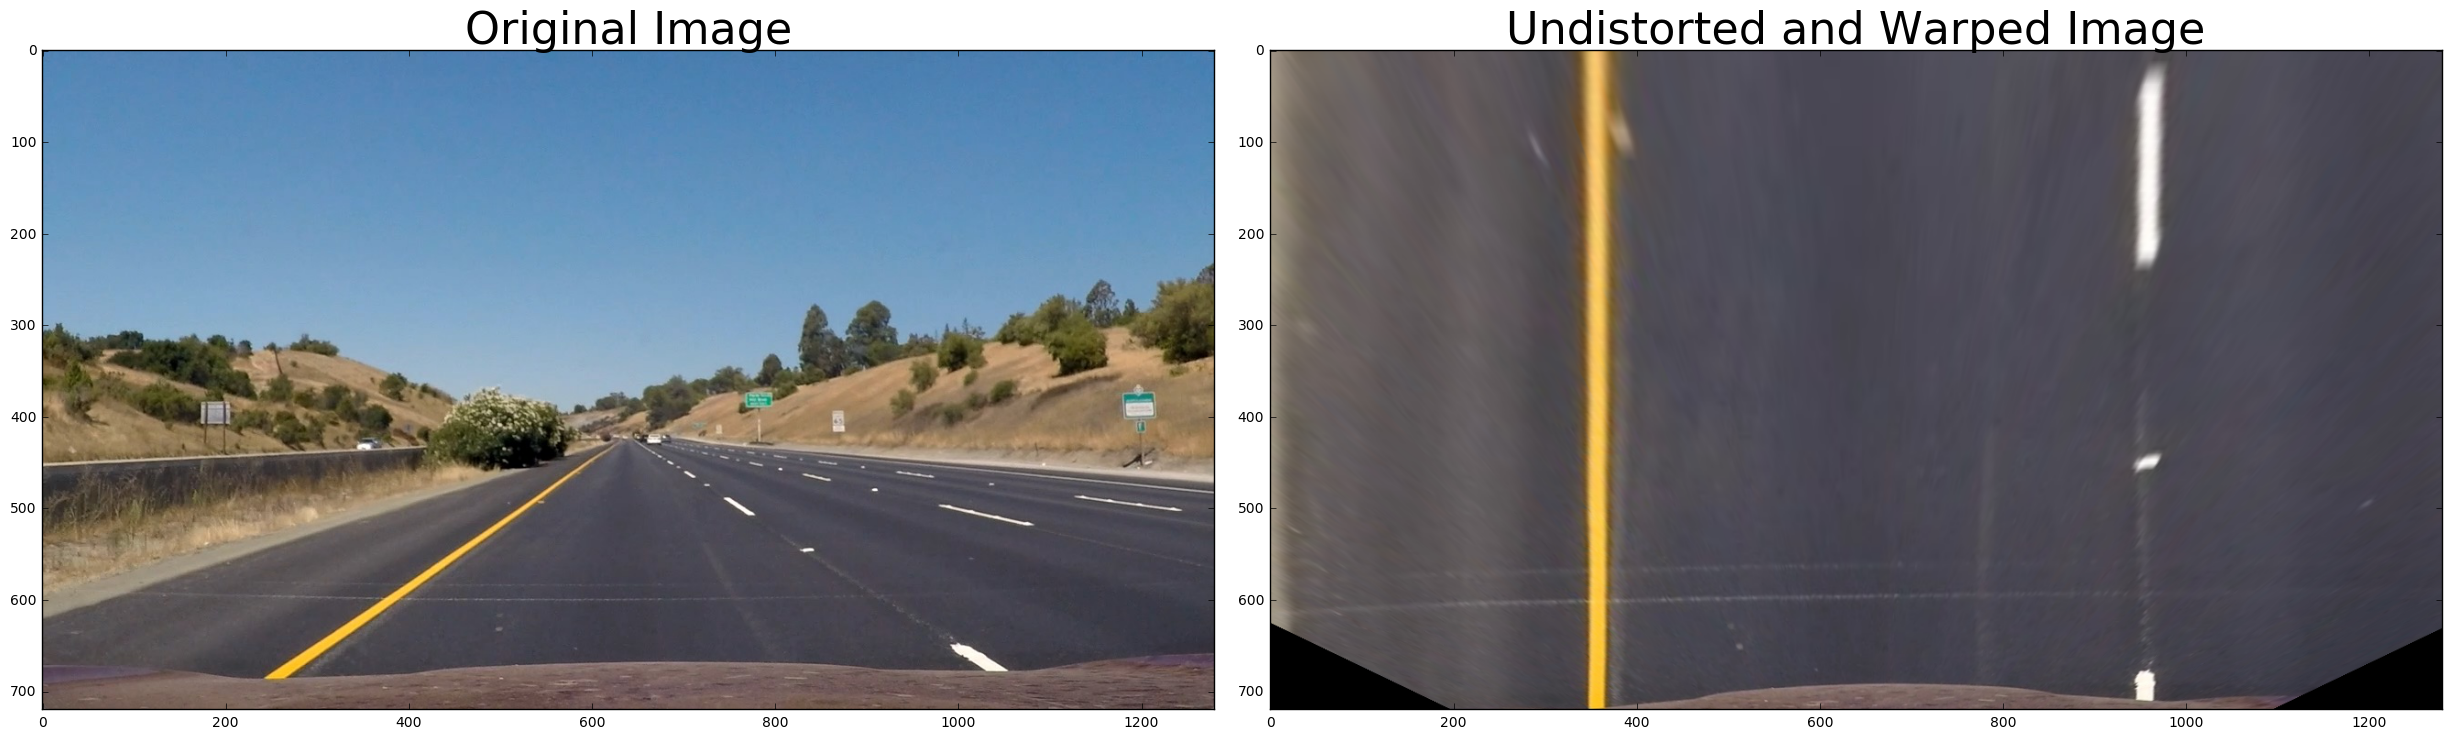

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_straight_lines)
ax1.set_title('Original Image', fontsize=32)
ax2.imshow(img_unwarp)
ax2.set_title('Undistorted and Warped Image', fontsize=32)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### Gradient, Color Filtering

In [17]:
img_unwarp_cfilt = apply_gradx_color_filter(img_unwarp)

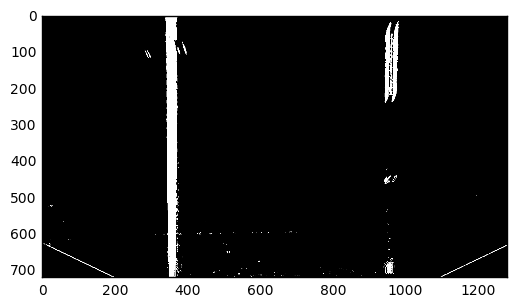

In [18]:
plt.imshow(img_unwarp_cfilt, cmap='gray')

### 5a. Find Lane Lines (Sliding Window)

In [19]:
def find_lane_pixels(binary_warped, nwindows=9, margin=100, min_pixels=50):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
                              (win_xleft_high,win_y_high),
                      (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
                              (win_xright_high,win_y_high),
                      (0,255,0), 2)
        
        ### indIdentify the nonzero pixels in x and y within the window ###
        good_left_inds = np.where((nonzerox >= win_xleft_low) &
                                  (nonzerox < win_xleft_high) &
                                  (nonzeroy >= win_y_low) &
                                  (nonzeroy < win_y_high))[0]
        # list(zip(nonzerox[nz_left], nonzeroy[nz_left]))
        good_right_inds = np.where((nonzerox >= win_xright_low) &
                                  (nonzerox < win_xright_high) &
                                  (nonzeroy >= win_y_low) &
                                  (nonzeroy < win_y_high))[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > min_pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > min_pixels:
            leftx_current = int(np.mean(nonzerox[good_left_inds]))
        
        if len(good_right_inds) > min_pixels:
            rightx_current = int(np.mean(nonzerox[good_right_inds]))
            

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    ### Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = np.polyval(left_fit, ploty)
        right_fitx = np.polyval(right_fit, ploty)
    except TypeError:
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img

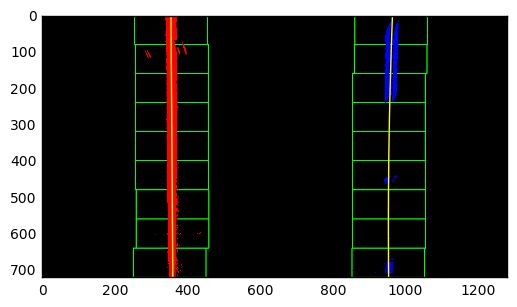

In [20]:
out_img = fit_polynomial(img_unwarp_cfilt)
plt.imshow(out_img)